### Create Train and Test Datasets
---

This notebook loads a dataset from synthetic neural activity signals then splits it into equal halves train and test datasets.
 
We then plot sequences from the two halves to see if they are organized correctly for next-timestep sequence-to-sequence prediction.

**Last update:** _13 December 2023_

#### Libraries
---

In [22]:
# %load_ext cudf.pandas
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader
from model._utils import LinearRegression
from data._utils import create_combined_dataset, split_combined_dataset
from utils import DEVICE, NEURON_LABELS, NUM_NEURONS, EXPERIMENT_DATASETS, SYNTHETIC_DATASETS

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Create datasets
---

In [23]:
%%time

# Create a single combined dataset from the one of the 8 experimental datasets of your choice
experimental_dataset = "Venkatachalam2024"
assert experimental_dataset in set(EXPERIMENT_DATASETS) | set(
    SYNTHETIC_DATASETS
), f"Invalid dataset: {experimental_dataset}"
datasets = {experimental_dataset: 1}  # a real worm neural dataset (1 worm)
combined_dataset, dataset_info = create_combined_dataset(datasets, num_labeled_neurons=None)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = num_val_samples = num_samples = 2
reverse = use_residual = False
use_smooth = True
train_split_first = False
train_split_ratio = 0.5
seq_len = 250
full_dataset, train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    use_smooth,
    train_split_first,
    train_split_ratio,
)

2024-10-21 13:43:42,434 - INFO - Using 1 worms from Venkatachalam2024 (random pick).
2024-10-21 13:43:42,437 - INFO - Combined dataset has 1 worms


CPU times: user 103 ms, sys: 204 ms, total: 308 ms
Wall time: 314 ms


#### Sample train and test sequences
---

In [24]:
%%time

# Get the sample from the train dataset
data_train, mask_train, metadata_train = train_dataset[-1]
X_train, Y_train = data_train[:-1], data_train[1:]
time_train = metadata_train["time_vec"][1:]
print(f"Train set\ninput:{X_train.shape}\ntarget:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n")

# NOTE: The last train sample comes right before the first test sample.

# Get the sample from the validation dataset
data_test, mask_test, metadata_test = val_dataset[0]
X_test, Y_test = data_test[:-1], data_test[1:]
time_test = metadata_test["time_vec"][1:]
print(f"Test set\ninput:{X_test.shape}\ntarget:{Y_test.shape}\nnmask:{mask_test.shape}\ntime:{time_test.shape}\n")

Train set
input:torch.Size([249, 300])
target:torch.Size([249, 300])
mask:torch.Size([300])
time:torch.Size([249])

Test set
input:torch.Size([249, 300])
target:torch.Size([249, 300])
nmask:torch.Size([300])
time:torch.Size([249])

CPU times: user 648 μs, sys: 0 ns, total: 648 μs
Wall time: 483 μs


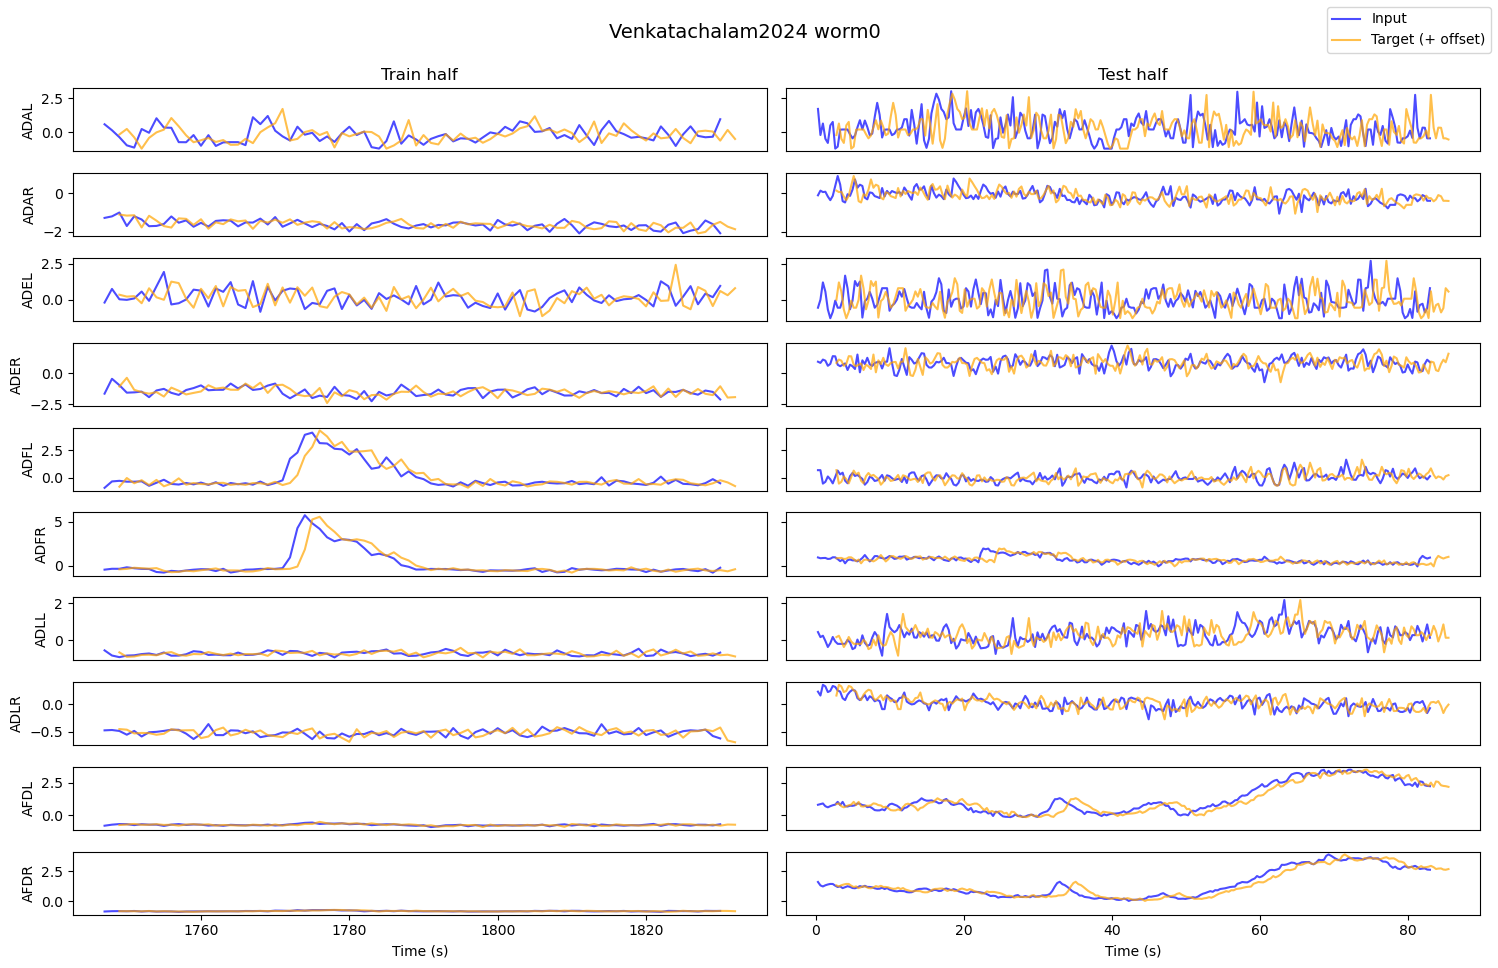

CPU times: user 1.25 s, sys: 17.4 ms, total: 1.27 s
Wall time: 1.11 s


In [25]:
%%time

# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train = mask_train.sum().item()
num_neurons_test = mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.numpy()")
    X = eval(f"X_{phase}.numpy()")
    Y = eval(f"Y_{phase}.numpy()")
    mask = eval(f"mask_{phase}.numpy()")
    worm_dataset = eval(f"metadata_{phase}['worm_dataset']")
    wormID = eval(f"metadata_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 100

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURON_LABELS[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURON_LABELS[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette=["blue", "orange"],
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURON_LABELS[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### Samples before and after training a model

In [26]:
%%time

# Create a single combined dataset from all the worms
datasets = dict(
    (dataset, "all") for dataset in EXPERIMENT_DATASETS
)  # a real worm neural dataset (all worms)
combined_dataset, dataset_info = create_combined_dataset(datasets, num_labeled_neurons=None)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = 32
num_val_samples = 32
reverse = use_residual = False
use_smooth = True
train_split_first = False
train_split_ratio = 0.5
seq_len = 100
full_dataset, train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    use_smooth,
    train_split_first,
    train_split_ratio,
)

# Initialize the model and optimizer
model = LinearRegression(NUM_NEURONS).to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.001)

# Create a GradScaler at the beginning of training
scaler = GradScaler()

2024-10-21 13:43:54,065 - INFO - Combined dataset has 919 worms


CPU times: user 7.55 s, sys: 3.79 s, total: 11.3 s
Wall time: 16.4 s


### Before training

In [40]:
%%time
# Get inputs and targets from dataloaders and outputs from model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    data_train, mask_train, metadata_train = next(iter(train_loader))
    X_train, Y_train = data_train[:, :-1], data_train[:, 1:]
    time_train = metadata_train["time_vec"][:, 1:]
    
    Y_pred_train = model(X_train.to(DEVICE), mask_train.to(DEVICE))
    print(f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n")

    data_test, mask_test, metadata_test = next(iter(val_loader))
    X_test, Y_test = data_test[:, :-1], data_test[:, 1:]
    time_test = metadata_test["time_vec"][:, 1:]
    
    Y_pred_test = model(X_test.to(DEVICE), mask_test.to(DEVICE))
    print(f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n")


X:torch.Size([1, 99, 300])
Y:torch.Size([1, 99, 300])
mask:torch.Size([1, 300])
time:torch.Size([1, 99])


X:torch.Size([1, 99, 300])
Y:torch.Size([1, 99, 300])
mask:torch.Size([1, 300])
time:torch.Size([1, 99])

CPU times: user 3.74 ms, sys: 143 μs, total: 3.88 ms
Wall time: 2.7 ms


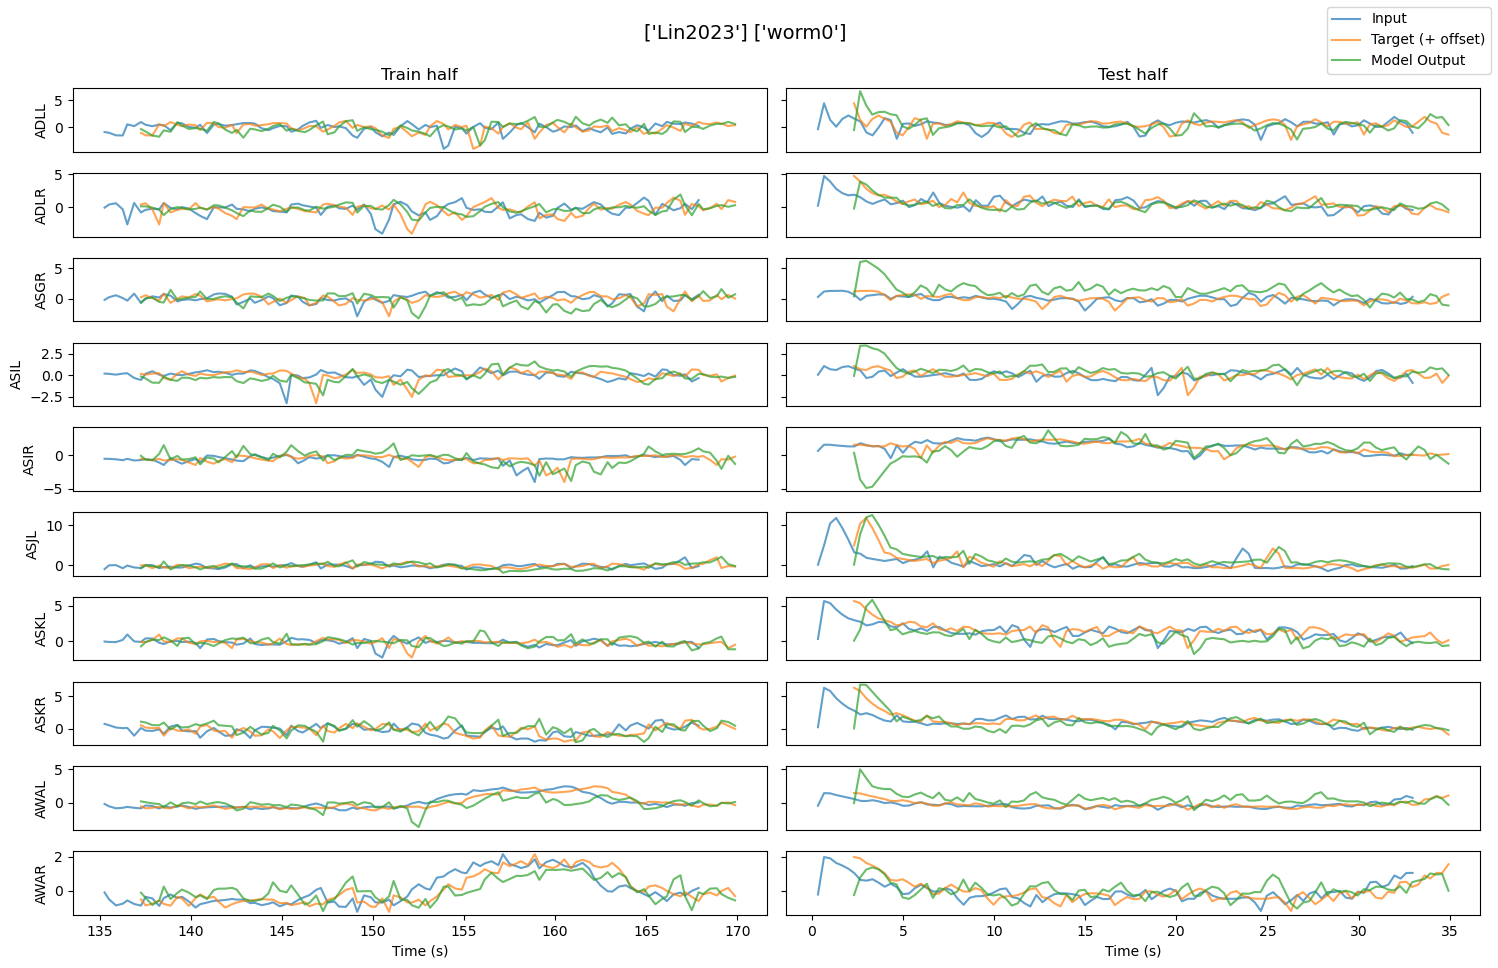

CPU times: user 901 ms, sys: 12.2 ms, total: 913 ms
Wall time: 916 ms


In [41]:
%%time

# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train, num_neurons_test = mask_train.sum().item(), mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.squeeze().cpu().numpy()")
    X = eval(f"X_{phase}.detach().squeeze().cpu().numpy()")  # input
    Y = eval(f"Y_{phase}.squeeze().cpu().numpy()")  # target
    Y_pred = eval(f"Y_pred_{phase}.detach().squeeze().cpu().numpy()")  # output
    mask = eval(f"mask_{phase}.detach().squeeze().cpu().numpy()")
    worm_dataset = eval(f"metadata_{phase}['worm_dataset']")
    wormID = eval(f"metadata_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 50

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURON_LABELS[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

        # Collect output data with time offset
        output_df = pd.DataFrame(
            {
                "Time": time + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y_pred[:, neuron_idx],
                "Type": "Model Output",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(output_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURON_LABELS[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette="tab10",
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURON_LABELS[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### After training

In [29]:
%%time

# @title Create a training pipeline

# Train for n_epochs
n_epochs = 1
criterion = model.loss_fn()
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}/{n_epochs}")

    # Training loop
    # Set model to training mode
    model.train()
    avg_train_loss = 0.0
    for batch in train_loader:
        # Get data and mask
        data, mask, info = batch
        X, Y = data[:, :-1], data[:, 1:]
        M = mask
        # Zero gradients
        optimizer.zero_grad()
        # Calculate the baseline loss
        baseline = criterion(output=X, target=Y, mask=M)
        # Forward pass
        Y_p = model(X.to(DEVICE), M.to(DEVICE))
        # Calculate loss
        loss = criterion(output=Y_p, target=Y.to(DEVICE), mask=M.to(DEVICE))
        avg_train_loss += loss.item() / len(train_loader)
        ### DEBUG ##
        if loss.isnan():
            print("Loss is NaN")
            print(
                f"X: {X.isnan().sum().item()}\nY: {Y.isnan().sum().item()}\nmask: {mask.isnan().sum().item()}"
            )
            break
        ### DEBUG ##
        # Check if the computed loss requires gradient (e.g. the NaivePredictor model does not)
        if loss.requires_grad:
            # Backward pass
            scaler.scale(loss).backward()
            # Update model weights
            scaler.step(optimizer)
            # Updates the scaler
            scaler.update()
    print(f"\tTrain loss: {avg_train_loss}")

    # Validation loop
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        avg_val_loss = 0.0
        for batch in val_loader:
            # Get data and mask
            data, mask, info = batch
            X, Y = data[:, :-1], data[:, 1:]
            M = mask
            # Calculate loss
            loss = criterion(output=Y_p, target=Y.to(DEVICE), mask=M.to(DEVICE))
            avg_val_loss += loss.item() / len(val_loader)
        ### DEBUG ##
        if loss.isnan():
            print("Loss is NaN")
            print(
                f"X: {X.isnan().sum().item()}\nY: {Y.isnan().sum().item()}\nmask: {mask.isnan().sum().item()}"
            )
            break
        ### DEBUG ##
        print(f"\t\tVal loss: {avg_val_loss}")

Epoch: 1/5


Loss is NaN
X: 297
Y: 297
mask: 0
	Train loss: nan
Loss is NaN
X: 0
Y: 0
mask: 0
CPU times: user 1min 13s, sys: 41.8 s, total: 1min 55s
Wall time: 1min 4s


In [39]:
for batch in val_loader:
    print(batch.shape)
    break

for batch in train_loader:
    print(batch.shape)
    break

AttributeError: 'list' object has no attribute 'shape'

In [30]:
%%time

# Get inputs and targets from dataloaders and outputs from model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    X_train, Y_train, mask_train, metadata_train = next(iter(train_loader))
    time_train = metadata_train["time_vec"]
    Y_pred_train = model(X_train.to(DEVICE), mask_train.to(DEVICE))
    print(
        f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
    )

    X_test, Y_test, mask_test, metadata_test = next(iter(val_loader))
    Y_pred_test = model(X_test.to(DEVICE), mask_test.to(DEVICE))
    time_test = metadata_test["time_vec"]
    print(f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n")

ValueError: not enough values to unpack (expected 4, got 3)

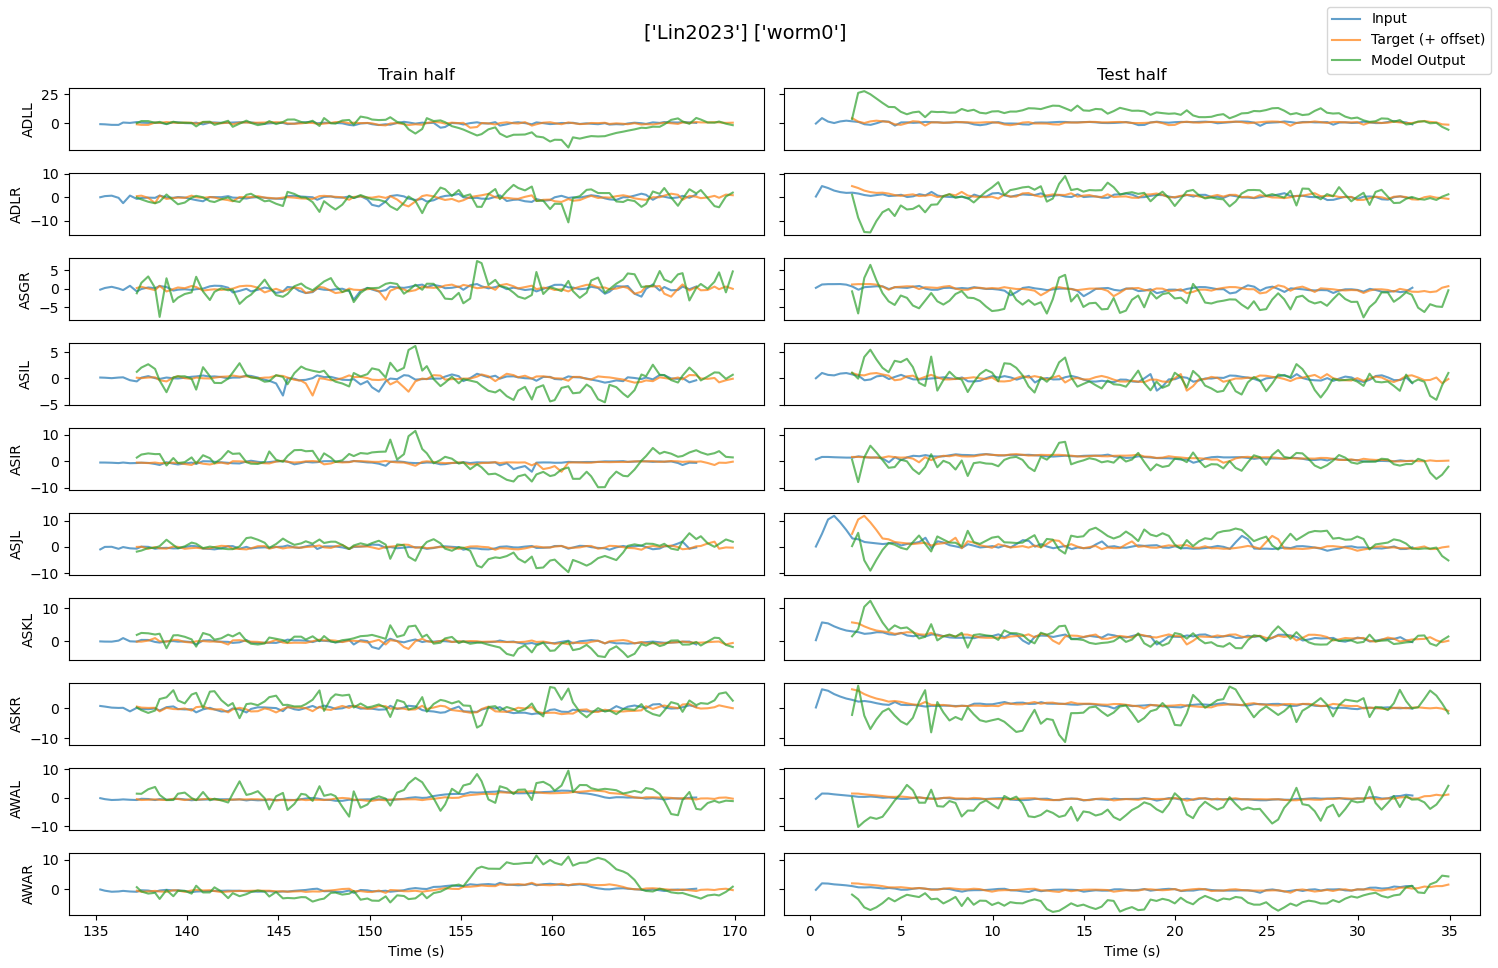

CPU times: user 1.34 s, sys: 52.8 ms, total: 1.4 s
Wall time: 1.4 s


In [31]:
%%time

# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train, num_neurons_test = mask_train.sum().item(), mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.squeeze().cpu().numpy()")
    X = eval(f"X_{phase}.detach().squeeze().cpu().numpy()")  # input
    Y = eval(f"Y_{phase}.squeeze().cpu().numpy()")  # target
    Y_pred = eval(f"Y_pred_{phase}.detach().squeeze().cpu().numpy()")  # output
    mask = eval(f"mask_{phase}.detach().squeeze().cpu().numpy()")
    worm_dataset = eval(f"metadata_{phase}['worm_dataset']")
    wormID = eval(f"metadata_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 50

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURON_LABELS[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

        # Collect output data with time offset
        output_df = pd.DataFrame(
            {
                "Time": time + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y_pred[:, neuron_idx],
                "Type": "Model Output",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(output_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURON_LABELS[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette="tab10",
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURON_LABELS[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### TODO: helper function for plotting 

In [32]:
# def plot_train_test_sample(train_sample, test_sample, model=None):
#     """
#     Plots a single sample from the train and test datasets.
#     Args:
#         train_sample (tuple): a single sample from the train dataset
#         test_sample (tuple): a single sample from the test dataset
#         model (nn.Module): a PyTorch model to use for prediction
#     """
#     # Check shapes
#     if train_sample.ndim == 3:  # could have been input as a batch
#         assert train_sample.shape[0] == 1  # batch size must be 1
#         train_sample = train_sample.squeeze(0)
#     if test_sample.ndim == 3:
#         assert test_sample.shape[0] == 1
#         test_sample = test_sample.squeeze(0)
#     assert (
#         train_sample.ndim == 2 and test_sample.ndim == 2
#     ), "Invalid sample shape. Please use a single train and test sample of shape (seq_len, num_neurons)."
#     X_train, Y_train, mask_train, metadata_train = train_sample
#     X_test, Y_test, mask_test, metadata_test = test_sample

#     return None